In [1]:
from pykospacing import Spacing
import pandas as pd
import numpy as np
import re
from konlpy.tag import Okt
import requests
import json
import time
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation

warnings.filterwarnings("ignore")

In [2]:
label_df = pd.read_csv('주요도시 풋살장 셔플 라벨.csv', encoding='utf-8-sig')

In [3]:
label_df['제목'] = label_df['제목'].astype(str)
label_df['내용'] = label_df['내용'].astype(str)

In [4]:
label_df = label_df.sample(frac=1, random_state=42)
label_df

,Label,제목,내용
5488,1,옥상 재테크 태양광 풋살장 루트톱바 변신 월 수백만원 임대료 수익 창출,옥상 재테크 태양광 풋살장 루트톱바 변신 월 수백만원 임대료 수익 창출 옥상이 금싸...
2855,1,풋살장휴공간측량,풋살장 조성 기존 노후된 풋살장을 새롭게 구상중이다 실 사용자와 관리자 감독관이 함...
2133,1,대구대구풋살장 대구 북구 에이스 풋살장,대구 북구에 위치하고 있는 에이스 풋살장입니다 지금은 태전동에서 국우동으로 이전했습...
37,1,양주 장흥 일영유원지 초원의 집 풋살장 축구장,일영유원지 장흥유원지 일영 초원의 집 일영 초원의 집 축구장 일영 초원의 집 풋살장...
2063,0,인조잔디 테니스장인조잔디 골프인조잔디 축구교실창업 풋살장창업 풋살장시공업체,안녕하세요 필드를 주름주는 사람들주식회사 스포츠 오딧세이입니다 체육시설 설계 인...
...,...,...,...
3772,1,대전축구클럽 슈퍼맨 실내축구아카데미 출동,안녕하세요 슈퍼맨 아카데미입니다 활동량이 많고 뛰어다니는 것을 좋아하며 친구들과 함...
5191,1,구로구 실내풋살장을 소개합니다,안녕하세요 실내풋살장 입니다 서울시 구로구 개봉동 매봉빌딩에 위치한 실내풋살장입니...
5226,1,대전축구교실 슈퍼맨아카데미 취미반 유소년을 위한 축구리그 개최,안녕하세요 대전축구교실 취미반 축구문화를 이끄는 대덕구 슈퍼맨축구아카데미 입니다 일...
5390,0,대전 프리즈비 모임 함께 할 횐님들을 모집합니다,대전소모임 대전운동모임 대전동호회 대전운동동호회 대전플라잉디스크 대전프리즈비 중고등...


- 라벨이 1인 것만 추출

In [5]:
df = label_df[label_df['Label']==1]

## 전처리

In [6]:
titles = df['제목'].tolist()
contents = df['내용'].tolist()

In [7]:
def preprocess(documents):
    # 불용어 불러오기
    with open('stopwords.txt', 'r', encoding='utf-8') as f:
        stopwords = f.read().splitlines()

    # 텍스트 전처리
    okt = Okt()
    preprocessed = []
    for doc in documents:
        # 형태소 분석
        lemmatized = okt.nouns(doc)
        # 불용어 제거 및 토큰화
        tokens = [word for word in lemmatized if word not in stopwords]
        preprocessed.append(' '.join(tokens))

    return preprocessed

In [8]:
new_contents = preprocess(contents)

In [9]:
new_contents

['옥상 재테크 태양광 풋살 루트 톱바 변신 만원 임대료 수익 창 옥상 금 싸라기 재테크 수단 옥상 태양광 발전소 풋살 도심 옥상 루프 톱 바나 통신 중계 소 수익 공간 탈바꿈 식 건물 부가가치 주목 접근성 옥상 건물 몸값 덩달아 꿈틀 거리 옥상 재테크 가장 인기 건 태양광 사업 물류 창고 제조 공장 옥상 태양광 발전 사업자 임대료 기존 건물 옥상 산림 자연환경 훼손 태양광 패널 설치 수 최근 더욱 인기 옥상 체육 시설 풋살 수영장 공간 활용 극대 서울 양평동 롯데 마트 평점 주차장 옥상 공간 지난 풋살 활용 풋살 개 데 가량 투자 햇빛 절대 조건 태양광 달리 야간 활용 수 게 강점 회사 투자 비용 안 회수 서울시 상가 백화점 옥상 부지 풋살 체육 시설 조성 사례 총 건 달 루프 톱바 태양광 스포츠 시설 옥상 비즈니스 정부 식품위생법 시행 규칙 안전 위생 기준 충족 옥상 루프 톱 수 루프 톱 보유 건물 임대료 매가 서울 용산 해방촌 공인 관계자 루프 톱 포함 상가 임대료 일반 상가 당 만원 형성 아예 설계 옥상 활용 수 건물 늘 옥상 실내 공간 마련 아래층 식 옥상 공간 이제 활용 가치 공간 탈바꿈 활용',
 '풋살 조성 기존 노후 풋살 구상 실 사용자 관리자 감독 관 의견 땀 땀 평가 땀 눈 땀 고민 설계 땀 늘 내 건축물 설계 철학 공간 측량 토목 감리 드론 측량 실시 설계 광주 토목 설계 담양 토목 설계 토목 설계 신안 토목 설계 무안 토목 설계 순천 토목 설계 함평 토목 설계 진도 토목 설계 해남 토목 설계 토목 설계 나주 토목 설계 장흥 토목 설계 전남 토목 설계 전국',
 '대구 북구 위치 에이스 풋살 지금 태전동 국우동 이전 착오 에이스 풋살 대구광역시 북구 구리 주소 대구 북구 국우동 예약 문의 전화 시기 주차장 홍익 돈가스 주차장 구장 주차 시 이후 홍익 돈가스 주차장 이용 대기실 풋살 경기 다가 수 대기실 에이스 풋살',
 '유원지 장흥유원지 일영 초원 집 일영 초원 집 축구장 일영 초원 집 풋살 구장 개 축구장 개 풋살 개 인원 축구장 인원

- 문서의 벡터화

In [10]:
vectorizer = CountVectorizer()

df1 = vectorizer.fit_transform(new_contents)

## 혼란도를 이용한 최적의 토픽 수 선정

In [11]:
def calc_pv_coherence(countVector, start=5, end=30, max_iter=10,topic_wp=0.1, doc_tp=1.0):
    num = []
    per_value = []
    for i in range(start,end+1):
        lda = LatentDirichletAllocation(n_components=i,max_iter=max_iter,
                                       topic_word_prior=topic_wp,
                                       doc_topic_prior=doc_tp,
                                       learning_method='batch', n_jobs=-1,
                                       random_state=0)
        lda.fit(countVector)
        num.append(i)
        pv = lda.perplexity(countVector) # 혼란도를 구하는 메서드
        per_value.append(pv)
        
        print(f'토픽 수: {i}, 혼란도: {pv:0.4f}')
    
    plt.plot(num,per_value,'g-')
    plt.xlabel("토픽 수:")
    plt.ylabel("혼란도: ")
    plt.show()
    return per_value

토픽 수: 5, 혼란도: 924.3827
토픽 수: 6, 혼란도: 920.9365
토픽 수: 7, 혼란도: 890.3939
토픽 수: 8, 혼란도: 878.6458
토픽 수: 9, 혼란도: 882.8774
토픽 수: 10, 혼란도: 884.4437
토픽 수: 11, 혼란도: 882.4065
토픽 수: 12, 혼란도: 875.7015
토픽 수: 13, 혼란도: 871.0076
토픽 수: 14, 혼란도: 862.0122
토픽 수: 15, 혼란도: 863.4699
토픽 수: 16, 혼란도: 860.2584
토픽 수: 17, 혼란도: 863.9896
토픽 수: 18, 혼란도: 859.8863
토픽 수: 19, 혼란도: 866.3276
토픽 수: 20, 혼란도: 864.7042
토픽 수: 21, 혼란도: 868.2150
토픽 수: 22, 혼란도: 868.2316
토픽 수: 23, 혼란도: 875.1340
토픽 수: 24, 혼란도: 877.6672
토픽 수: 25, 혼란도: 876.6077
토픽 수: 26, 혼란도: 882.7262
토픽 수: 27, 혼란도: 889.0703
토픽 수: 28, 혼란도: 893.1011
토픽 수: 29, 혼란도: 896.5565
토픽 수: 30, 혼란도: 902.6991


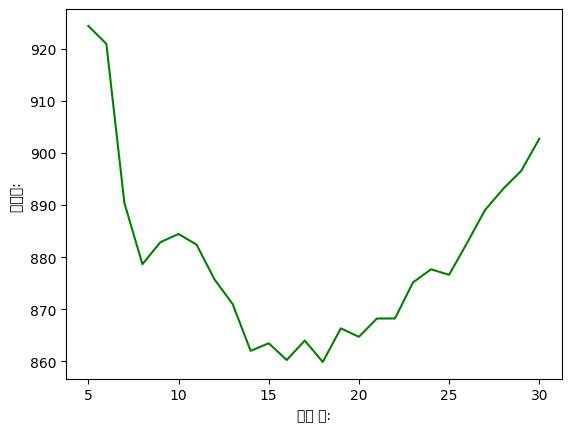

In [12]:
per_values = calc_pv_coherence(df1,start=5,end=30)

## 토픽 학습

In [13]:
lda = LatentDirichletAllocation(n_components=18, # 토픽의 수
                               n_jobs= -1,
                               random_state=0,
                               max_iter=10,
                                topic_word_prior=0.1,
                               doc_topic_prior=1.0,
                               learning_method='batch')

%time futsal_topics = lda.fit_transform(df1)

CPU times: total: 1.64 s
Wall time: 3.28 s


## 토픽 출력

In [14]:
for topic_idx, topic in enumerate(lda.components_):
    print("토픽 #%d: " % topic_idx, end='')
    print(", ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]))

토픽 #0: 설치, 카페, 조명, 시설, 풋살, 체육, 스포츠, 작업, 휀스, 그물
토픽 #1: 선수, 경기, 축구, 대전, 대회, 중앙, 훈련, 모집, 취미, 풋살
토픽 #2: 대구, 풋살, 청소, 경산, 부천, 달서구, 축구, 대구광역시, 마을, 축구화
토픽 #3: 풋살, 운동, 구장, 공원, 경기, 생각, 이용, 사람, 정도, 잔디
토픽 #4: 축구장, 인천, 지역, 청라, 서구, 코탑, 송도, 성남, 칠곡, 마포
토픽 #5: 풋살, 실내, 부산, 스토, 운동, 케이, 이동, 구장, 정관, 블로그
토픽 #6: 시설, 임대, 옥상, 상가, 체육, 운영, 매물, 만원, 건물, 문의
토픽 #7: 풋살, 매치, 여자, 매칭, 용병, 참여, 진행, 인원, 대구, 경기
토픽 #8: 축구, 시흥, 교실, 플랑드르, 안내, 수업, 롯데, 문자, 신청, 마트
토픽 #9: 창업, 센터, 계획, 체육, 게임, 관악, 농구장, 유아, 개설, 건설
토픽 #10: 축구, 교실, 광주, 울산, 풋살, 수업, 소년, 북구, 풋볼, 레슨
토픽 #11: 축구, 소년, 감독, 선수, 교육, 코치, 프로, 클럽, 출신, 지도자
토픽 #12: 풋살, 인조잔디, 시공, 구장, 스포츠, 옥상, 용산, 베이스, 잔디, 아디다스
토픽 #13: 축구, 교실, 포장, 철거, 농구, 골프, 배드민턴, 광명, 위닝, 문의
토픽 #14: 축구, 인천, 성인, 재생, 서창, 레슨, 수업, 훈련, 접기, 어린이
토픽 #15: 풋살, 구장, 이용, 예약, 위치, 주차, 경기도, 주차장, 풋볼, 공간
토픽 #16: 풋살, 대관, 파크, 필드, 예약, 스타, 스포츠, 서비스, 농구장, 부천
토픽 #17: 축구, 교실, 대전, 클럽, 아카데미, 레슨, 실내, 풋살, 슈퍼맨, 대덕구
